In [1]:
import os
import torch
import sys

model_lib_path = "/home/jianih/research/LASER/LASER-unified/src/models"
sys.path.append(model_lib_path)

from llava_clip_model_v3 import PredicateModel as PredicateModel_v3

all_model_dir = "/home/jianih/research/LASER/data/LLaVA-Video-178K-v2/models"
model_dir = os.path.join(all_model_dir, f"ensemble-02-10")
model_name = "ensemble-2025-02-10-14-57-22"
epoch = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_model(model_dir, model_name, epoch, device):
    model_name = model_name + f'.{epoch}.model'
    predicate_model = torch.load(os.path.join(model_dir, model_name), map_location=device, weights_only=False)
    return predicate_model



In [2]:
import sys
sys.path.append("/home/jianih/research/GroundingDINO")
from groundingdino.util.inference import Model as gd_Model
from groundingdino.util.inference import load_image as load_gd_image
from groundingdino.util.utils import get_phrases_from_posmap
import torch
import math
from PIL import Image

In [3]:
home_dir = os.path.expanduser("~")
sam_dir = os.path.join(home_dir, "research/sam2")
sam_checkpoint_dir = os.path.join(sam_dir, "checkpoints")

# /home/jianih/research/Grounded-SAM-2/grounding_dino/groundingdino/config
gd_dir = os.path.join(home_dir, "research/GroundingDINO")
gd_checkpoint_dir = os.path.join(gd_dir, "checkpoints")
gd_config_dir = os.path.join(gd_dir, "groundingdino/config")
assert os.path.exists(gd_dir)
assert os.path.exists(gd_checkpoint_dir)
assert os.path.exists(gd_config_dir)


##### load grounding dino #####
gd_config_path = os.path.join(gd_config_dir, "GroundingDINO_SwinT_OGC.py") 
gd_checkpoint_path = os.path.join(gd_checkpoint_dir, "groundingdino_swint_ogc.pth")
assert os.path.exists(gd_config_path)
assert os.path.exists(gd_checkpoint_path)

BOX_THRESHOLD = 0.35
TEXT_THRESHOLD = 0.25
device = "cuda:0"

grounding_model = gd_Model(
            model_config_path=gd_config_path, 
            model_checkpoint_path=gd_checkpoint_path
            
        )
grounding_model.model = grounding_model.model.to("cuda:0")

final text_encoder_type: bert-base-uncased


In [4]:

def preprocess_caption(caption: str) -> str:
    result = caption.lower().strip()
    return result if result.endswith(".") else result + "."

def predict_gd(grounding_model, image, classes, box_threshold=0.5, text_threshold=0.4):
        caption = ". ".join(classes)
        processed_caption = preprocess_caption(caption)
        processed_image = grounding_model.preprocess_image(image_bgr=image).to(grounding_model.device)

        with torch.no_grad():
            outputs = grounding_model.model(processed_image.unsqueeze(0), captions=processed_caption)

        prediction_logits = outputs["pred_logits"].cpu().sigmoid()[0]  # (batch_size, nq, 256)
        prediction_boxes = outputs["pred_boxes"].cpu()[0]  # (batch_size, nq, 4)

        all_detections = []

        tokenizer = grounding_model.model.tokenizer

        mask = prediction_logits.max(dim=1)[0] > box_threshold
        logits = prediction_logits[mask]  # (n, 256)
        boxes = prediction_boxes[mask]  # (n, 4)

        tokenized = tokenizer(caption)

        phrases = [
            get_phrases_from_posmap(logit > text_threshold, tokenized, tokenizer).replace('.', '')
            for logit in logits
        ]

        logits = logits.max(dim=1)[0]

        source_h, source_w, _ = image.shape
        detections = grounding_model.post_process_result(
            source_h=source_h,
            source_w=source_w,
            boxes=boxes,
            logits=logits
        )
        class_id = grounding_model.phrases2classes(phrases=phrases, classes=classes)
        detections.class_id = class_id
        all_detections.append(detections)

        return all_detections

In [5]:
import cv2
image_path = "/home/jianih/research/EmbodiedBench/running/eb_nav/InternVL2_5-38B_multistep_baseline_gd_two_imgs/visual_appearance/episode_1_step_4_20250416_201456_front.png"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [6]:
import matplotlib.pyplot as plt

def list_depth(lst):
    """Calculates the depth of a nested list."""
    if not (isinstance(lst, list) or isinstance(lst, torch.Tensor)):
        return 0
    elif (isinstance(lst, torch.Tensor) and lst.shape == torch.Size([])) or (isinstance(lst, list) and len(lst) == 0):
        return 1
    else:
        return 1 + max(list_depth(item) for item in lst)
    
def normalize_prompt(points, labels):
    if list_depth(points) == 3: 
        points = torch.stack([p.unsqueeze(0) for p in points])
        labels = torch.stack([l.unsqueeze(0) for l in labels])
    return points, labels

# modify this function to take in a bbox label and show it
def show_box(box, ax, object_id, label='hi'):
    if len(box) == 0:
        return
    
    cmap = plt.get_cmap("gist_rainbow")
    cmap_idx = 0 if object_id is None else object_id
    color = list(cmap((cmap_idx * 47) % 256))
    
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor=color, facecolor=(0,0,0,0), lw=0.5))
    
    if label is not None:
        # ax.text(x0, y0 - 5, label, color='white', fontsize=10, backgroundcolor=np.array(color[:3]), alpha=color[3])
        ax.text(x0, y0 - 5, label, color='white', fontsize=10, alpha=color[3])
    
def show_prompts_one_image(frame_image, boxes, points, labels):
    # Create a figure and axis
    fig, ax = plt.subplots(1, figsize=(6, 6))

    # Display the frame image
    ax.imshow(frame_image)
    ax.axis('off')

    points, labels = normalize_prompt(points, labels)
    if type(boxes) == torch.Tensor:
        for object_id, (box, label) in enumerate(zip(boxes, labels)):
            if box is not None:
                show_box(box.cpu(), ax, object_id=object_id, label=label)
    elif type(boxes) == dict:
        for object_id, box in boxes.items():
            if box is not None:
                show_box(box.cpu(), ax, object_id=object_id)
    elif type(boxes) == list and len(boxes) == 0:
        pass
    else:
        raise Exception()
    
    # Show the plot
    plt.show()
    

In [76]:
sg_keywords = ["object"]
box_threshold = 0.2
text_threshold = 0.2

In [77]:
height, width = image.shape[0], image.shape[1]
detection_ls = predict_gd(grounding_model, image, sg_keywords, box_threshold=box_threshold, text_threshold=text_threshold)
assert len(detection_ls) == 1
detections = detection_ls[0]


def get_valid_bbox_val(v, b):
    return min(max(0, math.floor(v)), b)

scene_graph_text = []
reformated = torch.tensor([(get_valid_bbox_val(x1, width), 
            get_valid_bbox_val(y1, height),
            get_valid_bbox_val(x2, width), 
            get_valid_bbox_val(y2, height))
            for x1, y1, x2, y2 in detections.xyxy])


boxes = []
labels = []

for ct, class_id in enumerate(detections.class_id):
    boxes.append(reformated[ct])
    labels.append(sg_keywords[class_id])

if len(boxes) == 0:
    boxes = torch.tensor([])
else:
    boxes = torch.stack(boxes)

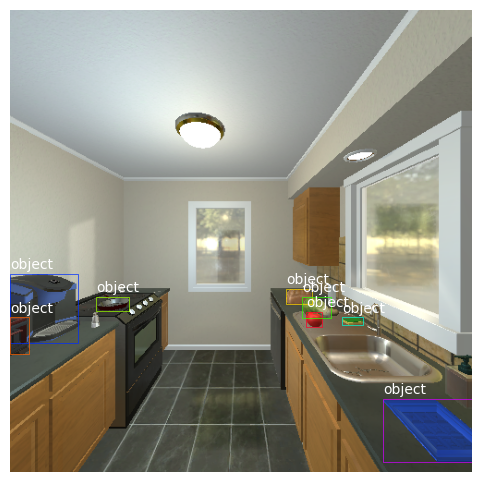

In [78]:
show_prompts_one_image(image, boxes, [], labels, )

In [10]:
def bbox_to_mask(bbox, frame_height, frame_width):
    """
    Converts a bounding box into a binary mask using torch tensors.

    Parameters:
    - bbox: A list or tuple of bounding box coordinates [xmin, ymin, xmax, ymax].
    - frame_height: The height of the frame.
    - frame_width: The width of the frame.

    Returns:
    - mask: A binary mask of shape (frame_height, frame_width) with dtype torch.bool.
    """
    # Create an empty mask with the same dimensions as the frame
    mask = np.zeros((frame_height, frame_width, 1), dtype=bool)
    
    # Extract bounding box coordinates
    xmin, ymin, xmax, ymax = bbox
    
    # Ensure coordinates are integers and within frame boundaries
    xmin = int(max(0, xmin))
    ymin = int(max(0, ymin))
    xmax = int(min(frame_width - 1, xmax))
    ymax = int(min(frame_height - 1, ymax))
    
    # Set the pixels inside the bounding box to True
    mask[ymin:ymax+1, xmin:xmax+1, :] = True
    
    return mask

In [11]:
import numpy as np
bboxes = detections.xyxy
height, width = image.shape[0], image.shape[1]
batched_pred_masks = [bbox_to_mask(bbox, height, width) for bbox in bboxes]

In [ ]:
classes = ["object", "other"]
unary1 = ["rectangular", "round", "other"]
uanry2 = ["yellowish", "greyish", "other"]
unary3 = ["hard", "soft", "other"]
unary4 = ["smooth", "rough", "other"]
unary_choices = [unary1, uanry2, unary3, unary4]

predicate_model = load_model(model_dir, model_name, epoch, device)

batched_object_ids = [[0, 0, i] for i in range(len(batched_pred_masks))]

predicate_model.clip_tokenizer.pad_token_id = 0
predicate_model.clip_tokenizer.pad_token = "<|endoftext|>"
batched_video_ids = [0]
batched_reshaped_raw_videos = [image]
all_unary_res = []
for unary in unary_choices:
    batched_image_cate_probs, batched_image_unary_probs, batched_image_binary_probs, dummy_prob = \
        predicate_model(
            batched_video_ids=batched_video_ids,
            batched_videos=batched_reshaped_raw_videos,
            batched_masks=batched_pred_masks,  # batched_object_ids * video_height * video_width
            batched_bboxes=bboxes,  # batched_object_ids * dict<bboxes>
            batched_names=[classes],  # Dataset-wise categorical labels
            batched_object_ids=batched_object_ids,  # [video_id, frame_id, object_id]
            batched_unary_kws=[unary],  # Dataset-wise unary predicate labels
            batched_binary_kws=[[]],  # Dataset-wise binary predicate labels
            batched_obj_pairs=[],  # Ground truth binary relations
            batched_video_splits=[0],  # [number of videos]
            batched_binary_predicates=[None],  # None indicates inference time
        )
    all_unary_res.append(batched_image_unary_probs)

In [33]:

def show_mask(mask, ax, obj_id=None, det_class=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
    else:
        cmap = plt.get_cmap("gist_rainbow")
        cmap_idx = 0 if obj_id is None else obj_id
        color = list(cmap((cmap_idx * 47) % 256))
        color[3] = 0.5
        color = np.array(color)
        
    mask_image = mask * color.reshape(1, 1, -1)

    # draw a box around the mask with the det_class as the label
    if not det_class is None:
        
        # Find the bounding box coordinates
        y_indices, x_indices, _ = np.where(mask > 0)
        if y_indices.size > 0 and x_indices.size > 0:
            x_min, x_max = x_indices.min(), x_indices.max()
            y_min, y_max = y_indices.min(), y_indices.max()
            rect = plt.Rectangle(
                (x_min, y_min),
                x_max - x_min,
                y_max - y_min,
                linewidth=1.5,
                edgecolor=color[:3],
                facecolor="none",
                alpha=color[3]
            )
            ax.add_patch(rect)
            ax.text(
                x_min,
                y_min - 5,
                f"{det_class}",
                color="white",
                fontsize=6,
                backgroundcolor=np.array(color),
                alpha=1
            )
            
    ax.imshow(mask_image)
    
def get_video_masks_visualization(video_tensor, 
                                  video_masks, 
                                  oid_class_pred=None,):
        
    for frame_id, image in enumerate(video_tensor):
        if frame_id not in video_masks:
            print("No mask for Frame", frame_id)
            continue
        
        masks = video_masks[frame_id]
        get_mask_one_image(image, masks, oid_class_pred)

def get_mask_one_image(frame_image, masks, oid_class_pred=None):
    # Create a figure and axis
    fig, ax = plt.subplots(1, figsize=(6, 6))

    # Display the frame image
    ax.imshow(frame_image)
    ax.axis('off')

    if type(masks) == list:
        masks = {i: m for i, m in enumerate(masks)}
        
    # Add the masks
    for obj_id, mask in masks.items():
        det_class = f"{obj_id}. {oid_class_pred[obj_id]}" if not oid_class_pred is None else None
        show_mask(mask, ax, obj_id=obj_id, det_class=det_class, random_color=False)

    # Show the plot
    return fig, ax


In [34]:
def format_masks(batched_object_ids, batched_pred_masks):
    new_masks = {}
    for (_, fid, oid), mask in zip(batched_object_ids, batched_pred_masks):
        if not fid in new_masks:
            new_masks[fid] = {}
        new_masks[fid][oid] = mask
            
    return new_masks

In [35]:
formated_masks = format_masks(batched_object_ids, batched_pred_masks)


In [ ]:
cate_res = {}

for (oid, cat), prob in batched_image_cate_probs[0].items():
    if not oid in cate_res:
        cate_res[oid] = {}
    cate_res[oid][cat] = prob.item()

In [ ]:
aware_kws = ["rectangular", "yellowish"]

unary_res = {}
for unary_res in all_unary_res:
    for  (fid, oid, kw) in unary_res[0].keys():
        if kw in aware_kws:
            unary_res[oid][cat] = unary_res[0][cat].item()

NameError: name 'all_unary_res' is not defined

In [ ]:
k = 5
aggr_res = {}

for oid in unary_res: 
    if not oid in aggr_res:
        aggr_res[oid] = 1
        for attr in unary_res[oid]:
            aggr_res[oid] *= unary_res[oid][attr]


sorted([(v, k) for k, v in aggr_res.items()], reversed =True)[:k]
            

[(0.01029801673444604, 2),
 (0.025304740077396987, 5),
 (0.02874306987091848, 11),
 (0.04293532048796315, 9),
 (0.0678395056814744, 8),
 (0.07785258972256968, 7),
 (0.09353119188285136, 1),
 (0.10488162917015399, 3),
 (0.11897028766698271, 0),
 (0.14550490710653863, 10),
 (0.23235019128639847, 6),
 (0.29815179157547583, 4)]

In [58]:
unary_res[4]

{'rectangular': 0.5447555780410767, 'yellowish': 0.8019609451293945}

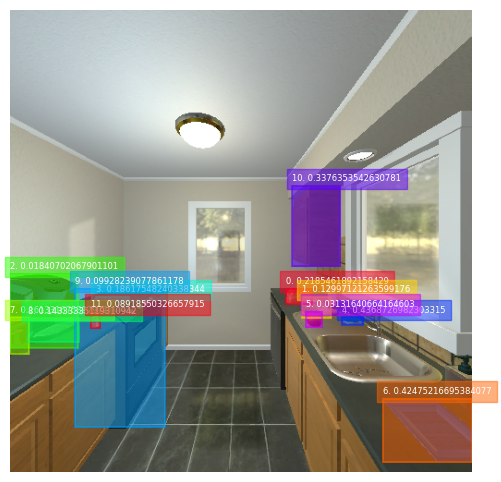

In [59]:
get_video_masks_visualization(batched_reshaped_raw_videos, 
                              formated_masks, 
                              oid_class_pred=comb_res,)